# Object Classification
## Transfer Learning


In [12]:
import numpy as np
import tensorflow as tf
import os
import sys
import keras
# os.path.abspath(os.path.dirname(__file__))
import matplotlib.pyplot as plt

from keras.api.applications.inception_v3 import InceptionV3


Create model. First part of model will be from Transfer Learning.\
InceptionV3 is good pretrained model for object classification.\
Second part of model is Dense Layers with 1 unit at the end for binary classification.

In [13]:
dir_path = os.getcwd()
os.getcwd()

'/home/c100rczyk/Projekty/Thesis_project_PWR/backend_3D/utilities'

# Download Images from :
https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [15]:
training_dir = f'/home/c100rczyk/Projekty/Thesis_project_PWR/backend_3D/data/cat_dog_dataset/training' 
testing_dir = (f'/home/c100rczyk/Projekty/Thesis_project_PWR/backend_3D/data/cat_dog_dataset/testing')
images_dir = f'/home/c100rczyk/Projekty/Thesis_project_PWR/backend_3D/data/cat_dog_dataset/'
images_dir

'/home/c100rczyk/Projekty/Thesis_project_PWR/backend_3D/data/cat_dog_dataset/'

Należy stworzyć generator zdjęć, który będzie generował dane
wrzucane do treningu. 
+ Wartości RGB należy przeskalować z zakresu 0-255 do 0-1
+ należy wykonać 'resize' na zdjęciach, aby pasowały do wejścia modelu
+ Należy wyznaczyć jakiej wielkości będą 'batche'

https://keras.io/guides/transfer_learning/  standarizing_data

Takie przygotowanie danych można zrobić albo w procesie samego przygotowania 
danych, aby były gotowe do wrzucenia do modelu, albo już w samym modelu jako
zdefiniowane warstwy specjalnie przygotowane do odpowiedniego przetworzenia
zdjęć które wrzucamy do modelu.
Podejście drugie jest o tyle wygodniejsze, że nie musimy dla każdego zbioru 
danych wykonywać preprocessingu, aby pasowały do naszego konkretnego modelu.


In [32]:
def process_image(image, label):
    image = tf.image.grayscale_to_rgb(image)  # Konwersja 1- lub 2-kanałowych obrazów na RGB
    return image, label

batch_data_train = keras.utils.image_dataset_from_directory(images_dir, 
                                                            labels='inferred',
                                                            batch_size=8,
                                                            image_size=(300, 300),
                                                            ).map(process_image)

batch_data_test = keras.utils.image_dataset_from_directory(testing_dir,
                                                           labels='inferred',
                                                           batch_size=8,
                                                           image_size=(300, 300),
                                                           ).map(process_image)

Found 29501 files belonging to 2 classes.


ValueError: in user code:

    File "/tmp/ipykernel_3649/1578556983.py", line 2, in process_image  *
        image = tf.image.grayscale_to_rgb(image)  # Konwersja 1- lub 2-kanałowych obrazów na RGB

    ValueError: Dimension 3 in both shapes must be equal, but are 9 and 3. Shapes are [?,300,300,9] and [?,300,300,3].


In [19]:
type(batch_data_train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.9354204..248.63335].


0
tf.Tensor([1 0 1 0 1 1 1 1], shape=(8,), dtype=int32)


2024-09-10 12:08:22.279116: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


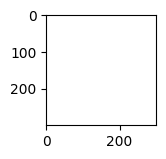

In [20]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(batch_data_train.take(1)):
    ax = plt.subplot(6,6, i+1)
    print(i)
    print(label)
    # print(image[0])
    #ax = plt.subplot(6,6, i+1)
    plt.imshow(image[0])


2024-09-10 12:08:22.886625: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


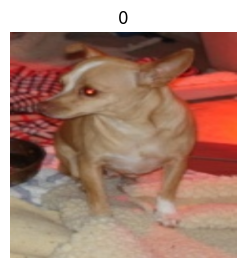

In [21]:
for images, labels in batch_data_train.take(1):
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[0]).astype("int32"))
    plt.title(int(labels[0]))
    plt.axis("off")


# Tworzenie sieci 

In [22]:
model_incV3 = InceptionV3(weights='imagenet',
                          include_top=False,
                          input_shape=(300, 300, 3))

In [23]:
model_input = model_incV3.input
incV3_output = model_incV3.get_layer('mixed6').output

In [24]:
inputs = keras.Input(shape=(300,300,3))
scale_rgb = keras.layers.Rescaling(scale=1./ 127.5, offset=-1)
scaled_input = scale_rgb(inputs)

In [25]:
model_out = model_incV3(scaled_input, training=False)

In [26]:
x = keras.layers.Flatten()(model_out)
x = keras.layers.Dense(units=256, activation='relu')(x)
x = keras.layers.Dense(units=16, activation='relu')(x)
model_output = keras.layers.Dense(units=1, activation='sigmoid')(x)

In [27]:
model = keras.models.Model(inputs, model_output)

In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,361,601 (211.19 MB)

 Trainable params: 55,327,169 (211.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
history = model.fit(batch_data_train,
          validation_data=batch_data_test,
          epochs=2)

Epoch 1/2


I0000 00:00:1725962926.070146    3831 service.cc:146] XLA service 0x736648005780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725962926.070171    3831 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-09-10 12:08:46.721397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 12:08:49.340944: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-10 12:08:51.382099: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   2/3688 ━━━━━━━━━━━━━━━━━━━━ 5:14 85ms/step - accuracy: 0.5000 - loss: 3.9674   

I0000 00:00:1725962957.866975    3831 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 183/3688 ━━━━━━━━━━━━━━━━━━━━ 4:18 74ms/step - accuracy: 0.8062 - loss: 1.1475

2024-09-10 12:09:31.385143: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_49679]